In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on 440 hz Sines

A very simple dataset, should be able to crush this. Sines all at 440 hz and unit amplitude. Start with all the same 440 hz waveform, them move on to different phases of 440. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 7 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
p = model.HParams(
    mixed_precision=False,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    n_chans=64
)

ds = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

ds_test = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

X, Y = datasets.to_tensor(ds, 20)

In [5]:
m = model.Wavenet(p)
tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

3072

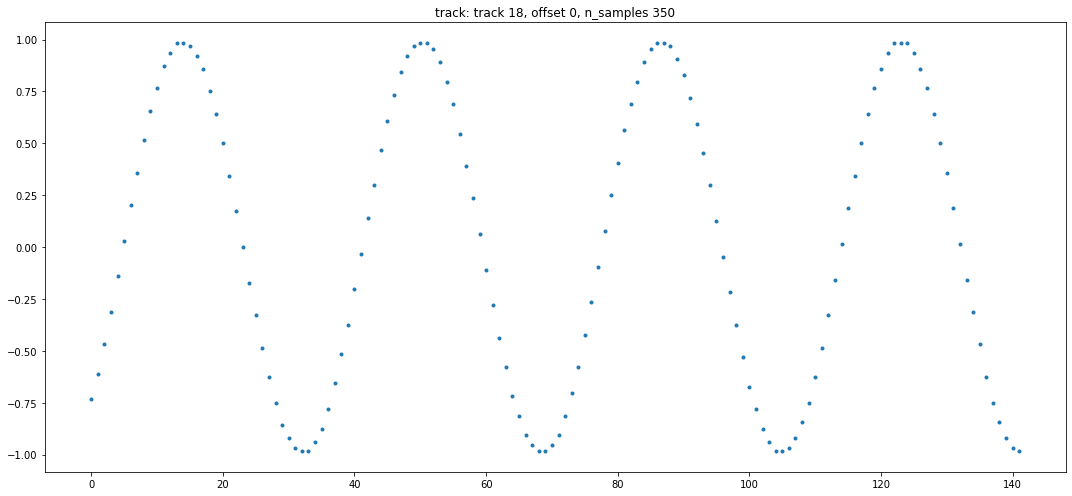

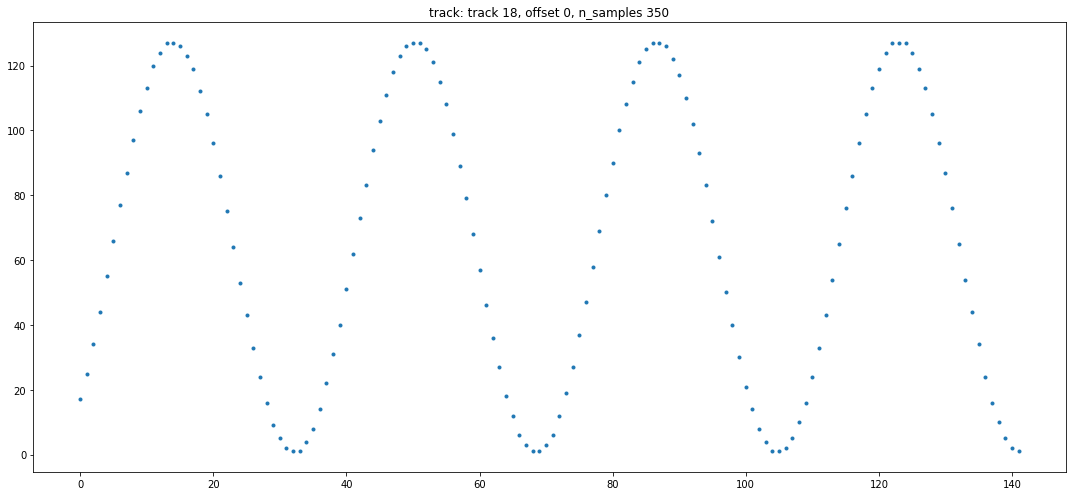

In [6]:
track_i = viz.plot_track(X, style='.')
viz.plot_track(Y, track_i, style='.')
track = X[track_i].numpy()
ipd.Audio(track, rate=p.sampling_rate)

In [7]:
t.train()

10:39 loss 0.33515 lr 5.320725e-07: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


In [8]:
def sample_simple(model, n_samples=48):
    generated = X.new_zeros((n_samples,) + X.size()[1:])
    flat = generated.view(generated.size(0), -1)

    # sampling
    for t in range(flat.size(1)):
        x = (generated.float() - 0) / 1
        y, _ = model(x)
        logits = y.view(flat.size() + (-1,))[:, t]
        dist = torch.distributions.categorical.Categorical(logits = logits)
        flat[:, t] = dist.sample()
        
    return generated

In [9]:
track = sample_simple(m)

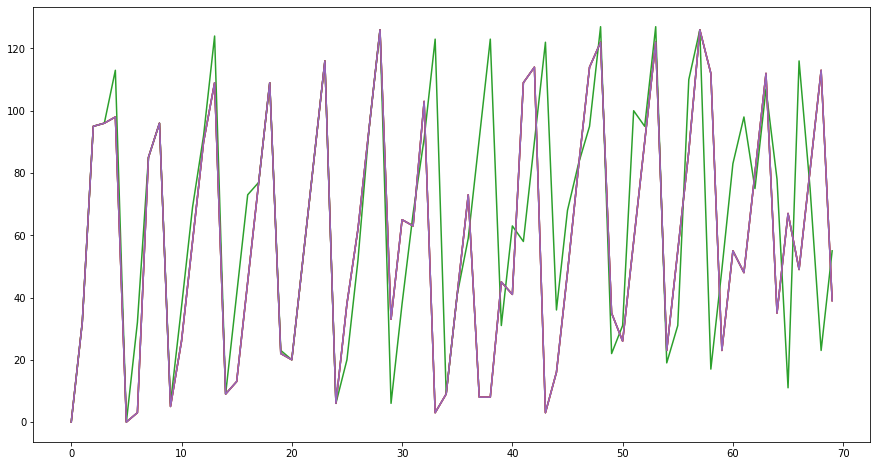

In [10]:
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.plot(track[i, 0, :70])